In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 1050594841 / Gaia DR3 6093967575460032896  Analysis (EA)

- revise existing https://www.aavso.org/vsx/index.php?view=detail.top&oid=13085 , which (incorrectly) points to the nearby TIC 312136246 / Gaia DR3 6093967571164369920 / ASASSN-V J140052.13-490014.8	 
- revision is primarily on identification and range,
- but new epoch / period / duration are revised, when the existing values do not fit the data

## TESS Data



In [2]:
tic = 1050594841

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 38,2021,QLP,600,1050594841,0.0,N/A
1,TESS Sector 65,2023,QLP,200,1050594841,0.0,N/A


LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 1050594841" SECTOR=38 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    1: <TessLightCurve LABEL="TIC 1050594841" SECTOR=65 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

In [3]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

RS (in R☉),2.064
MS (in M☉),1.400
Magnitude (TESS),12.21
T_eff (in K),6655.0


the target (crosshari) and the contaminant (red arrow and X). Identification from Gaia DR3 Variable

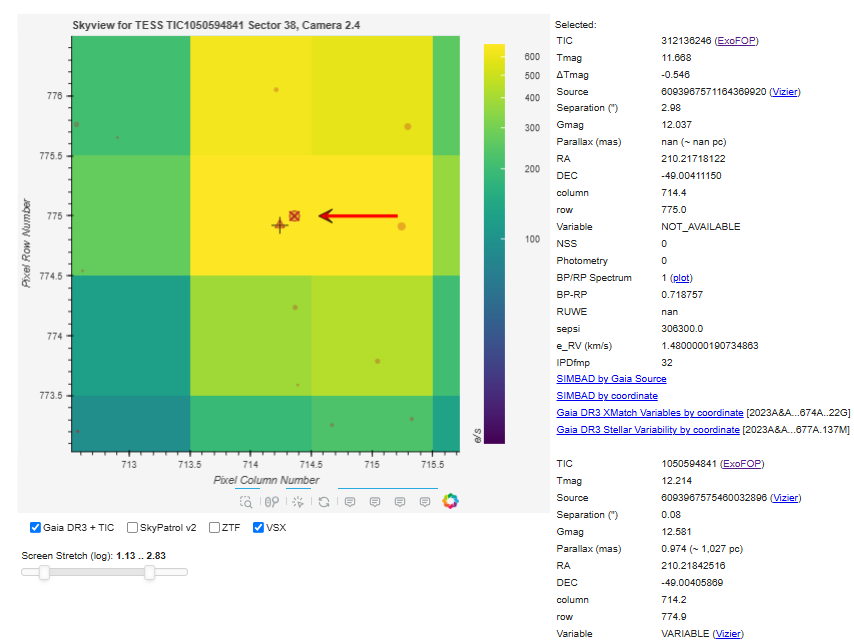


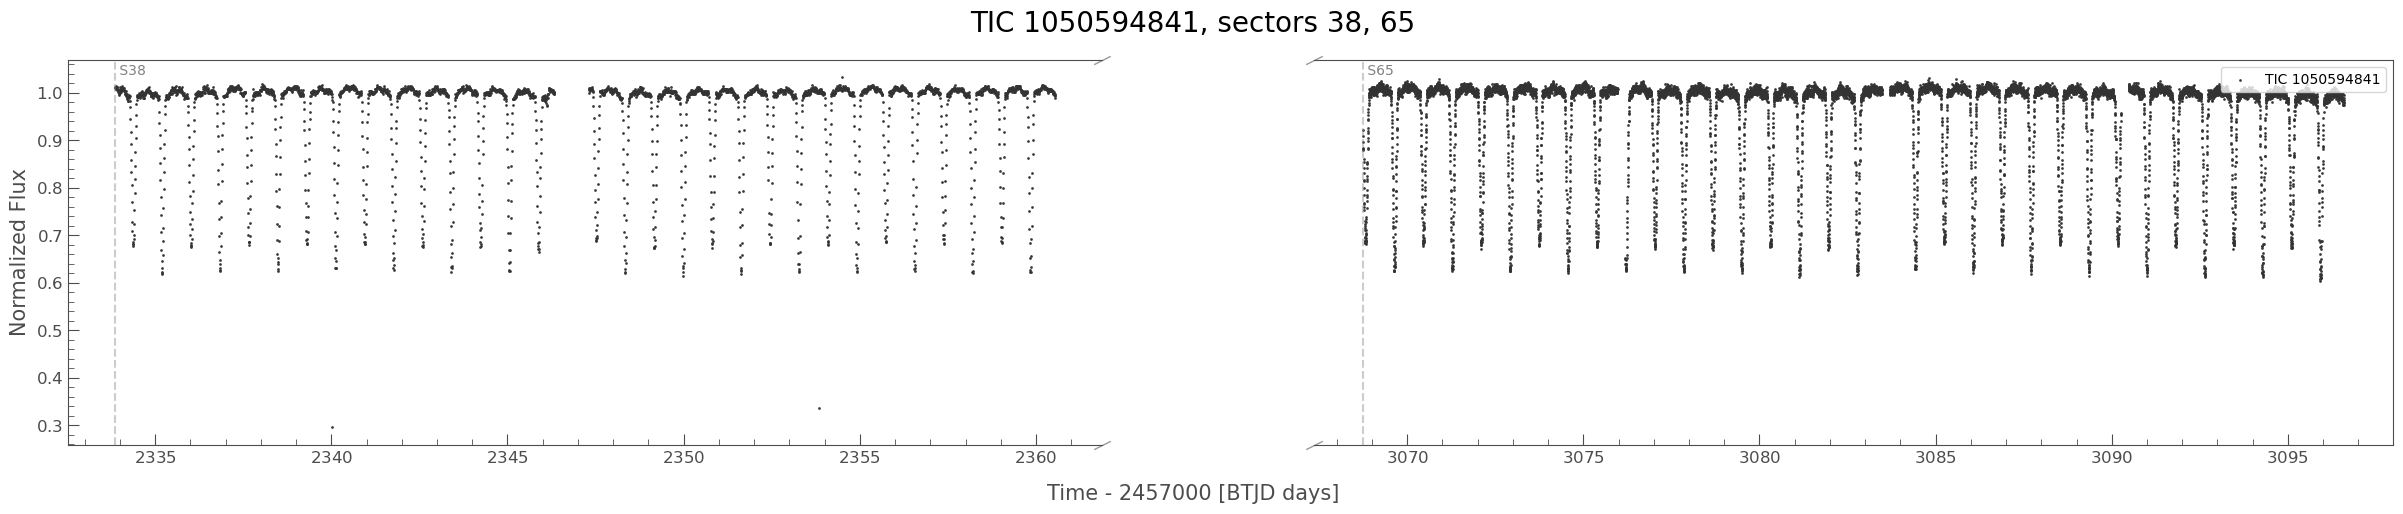

In [4]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

In [ ]:
# TODO: move to later verify eclipse duration

lc = lke.stitch(
    lcc_tess[2:],  # excluding the 30 minute cadence data, as the amplitude is slightly different
    ignore_incompatible_column_warning=True,    
)

# epoch=1738.99, duration_hr=6.44607, period=0.981189, label="s0014s0060tce1", transit_depth_percent=20.7912,
lc_f = lc.fold(epoch_time=1738.98, period=1.96239)
lc_f.label = f"TIC {tic} / V2165 Cyg"

ax = lc_f.scatter();

dur_hr = 6.2
dur_pct = dur_hr / 24 / 1.96239 * 100
ax.axvspan(0 - dur_hr / 24 / 2, 0 + dur_hr / 24 / 2, color="red", alpha=0.3);
# ax.set_xlim(-0.5, 0.5);
ax.legend(loc="lower left")
ax.set_title(f"Eclipse duration: {dur_hr} hours / {dur_pct:.0f}%");

---

## Gaia DR3 info (coordinate, etc.)

In [5]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=1.0, compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [14]:
primary_name = "Gaia DR3 6093967575460032896 "  # Gaia DR3 Variable provides the identification


## ASAS-SN data

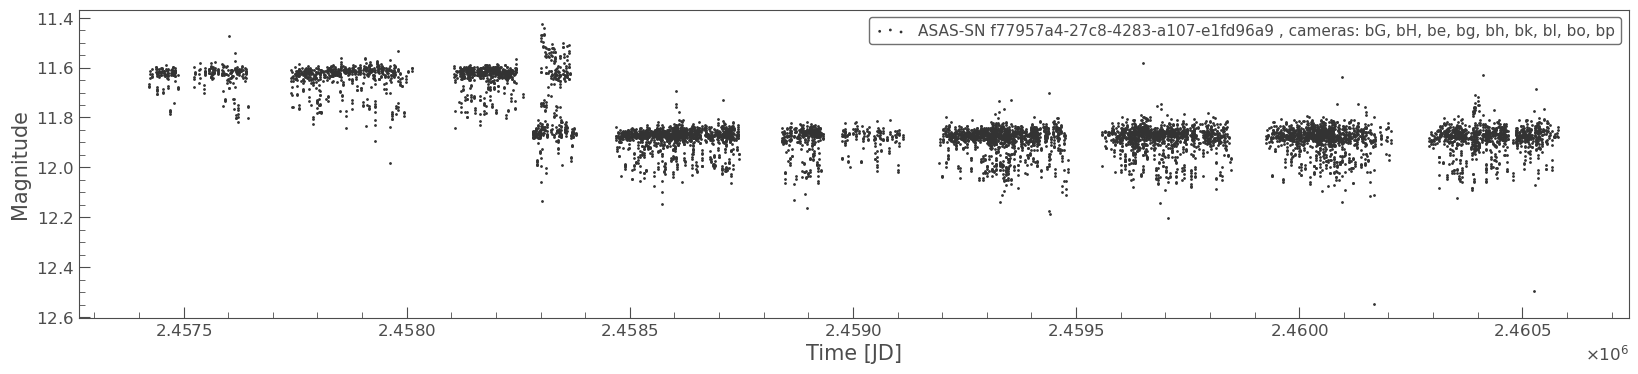

In [12]:
import lightkurve_ext_readers as lker
# reload(lker)

# https://asas-sn.osu.edu/sky-patrol/coordinate/f77957a4-27c8-4283-a107-e1fd96a9bebf
lc = lker.read_asas_sn_csv(f"{lk_download_dir}/targets/tic1050594841_asas_sn_light_curve_f77957a4-27c8-4283-a107-e1fd96a9bebf.csv")
lc = lc.select_flux("mag")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter(lc, ax=ax);
ax.set_title(ax.get_title());

lc_asassn = lc  # keep the reference in a meaninfgul name for use in subsequent cells

## Combining all data

TESS # data points: 15356
ASAS-SN V # data points: 1544
ASAS-SN g # data points: 6935


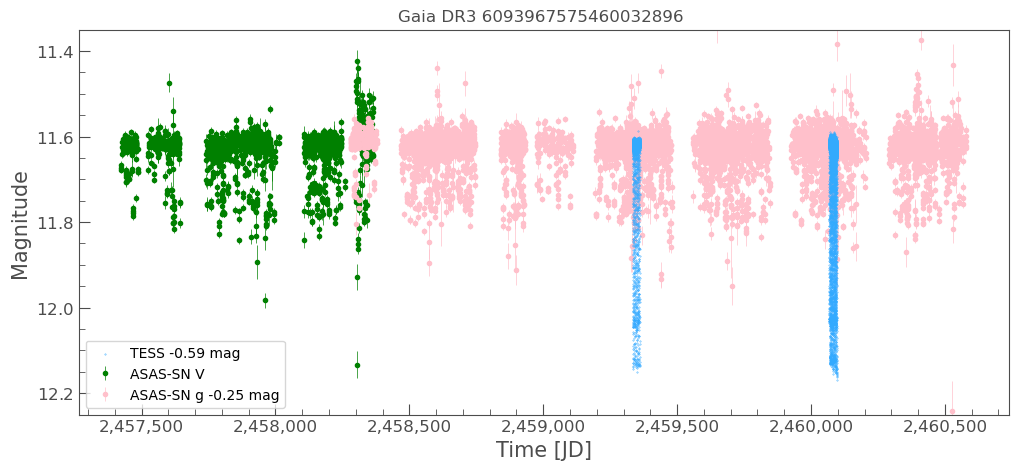

In [26]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True, )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-SN": lc_asassn,
    }, 
    shift_to="ASAS-SN V" 
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
ax.set_ylim(12.25, 11.35);

## Initial Rough epoch / period / duration

In [49]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_initial = 1.6431  # VSX / ASAS-SN value

epoch_time_hjd = 2458153.836  # VSX 
epoch_time_min_ii_hjd = epoch_time_hjd + period_initial / 2
epoch_time_min_ii_hjd = round(epoch_time_min_ii_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr_min_i_initial = 6.2    # TODO: 
duration_hr_min_ii_initial = 6.2
duration_hr = duration_hr_min_i_initial   # default shorthand 

## Crowding-correcting ASAS-SN

#### Determine contaminant V mag
Use transformd V mag from Gaia DR3 Gmag, with zero point adjustment using combined  Vmag max in ASAS-SN V as the reference.

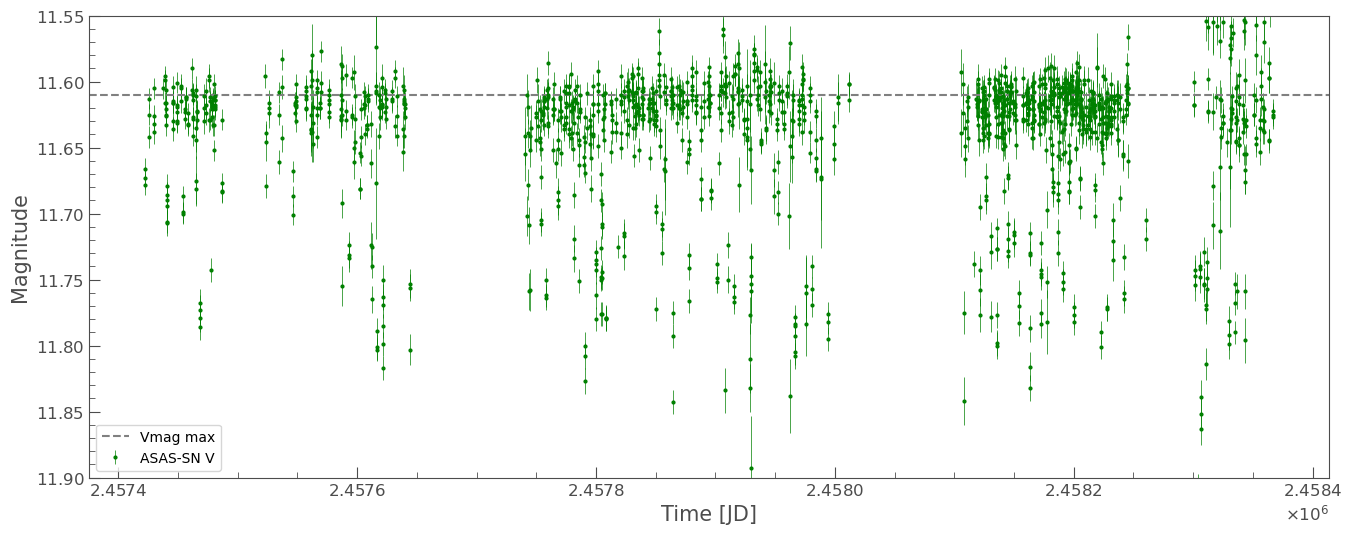

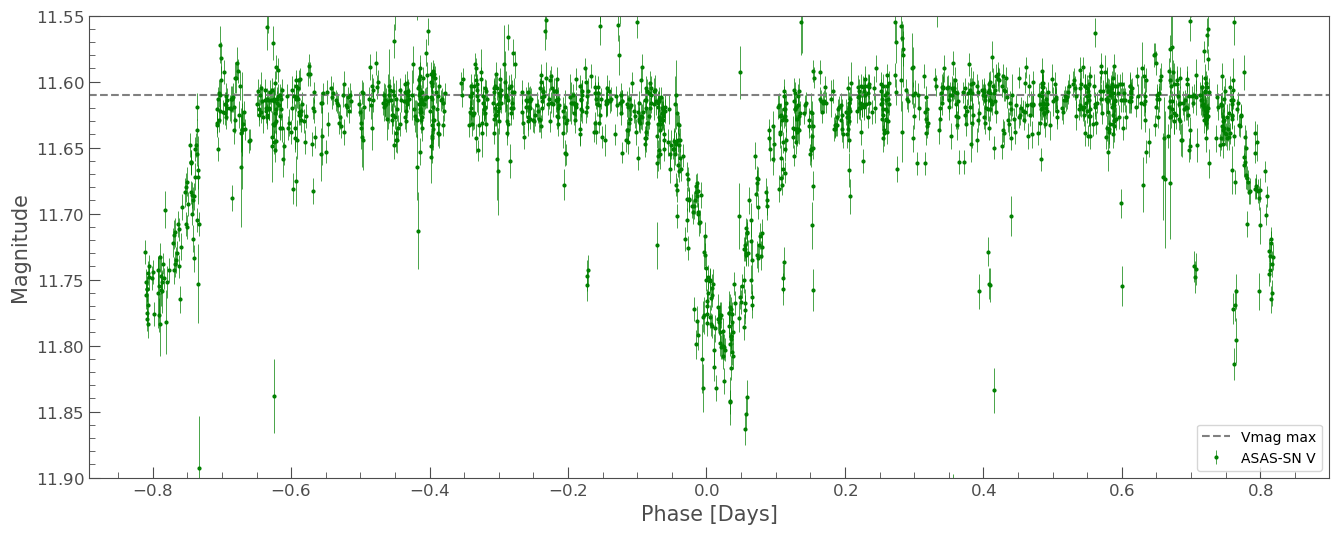

In [39]:
# deermine combined Vmag max by inspection
combined_v_mag_max  = 11.61

lc = lc_combined_dict["ASAS-SN V"].copy()
lc.label = "ASAS-SN V"
# lc = lc_combined_dict["TESS"]
ax = tplt.errorbar(lc, c="green", figsize=(16, 6));
ylim = (11.9, 11.55)
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

# a rough phase plot
ax = tplt.errorbar(lc.fold(period=1.6431, epoch_time=2458153.836), c="green", figsize=(16, 6));
# ax = tplt.scatter(lc.fold(period=1.6431, epoch_time=2458153.836), c="green", figsize=(16, 6));
ax.set_ylim(*ylim);
ax.axhline(combined_v_mag_max, c="gray", linestyle="--", label="Vmag max");
ax.legend();

In [40]:
target_g_vmag_max = lke.gaia_dr3_mag_to_vmag(12.574, 0.7191)  # max is from visual inspection Gaia DR3 photometry
print("target V max from Gaia G:", target_g_vmag_max)

contaminant_g_vmag = lke.gaia_dr3_mag_to_vmag(12.0365, 0.7188)  # from Gaia DR3 Gmag and B-R 
print("contaminant V from Gaia G:", contaminant_g_vmag)  

combined_g_vmag_max= lke.combine_magnitudes(target_g_vmag_max, contaminant_g_vmag)
print("Combined max V from Gaia G:", combined_g_vmag_max)

zero_point_offset = combined_v_mag_max - combined_g_vmag_max
print("Zero point offset:", zero_point_offset)

contaminant_vmag = contaminant_g_vmag + zero_point_offset
contaminant_vmag = round(contaminant_vmag, 2)
print("Contaminant Vmag, zero point adjusted, rounded:", contaminant_vmag)

target V max from Gaia G: 12.6969852310539
contaminant V from Gaia G: 12.159403133436738
Combined max V from Gaia G: 11.64268188094102
Zero point offset: -0.03268188094101987
Contaminant Vmag, zero point adjusted, rounded: 12.13


Max in Gaia DR3 G band

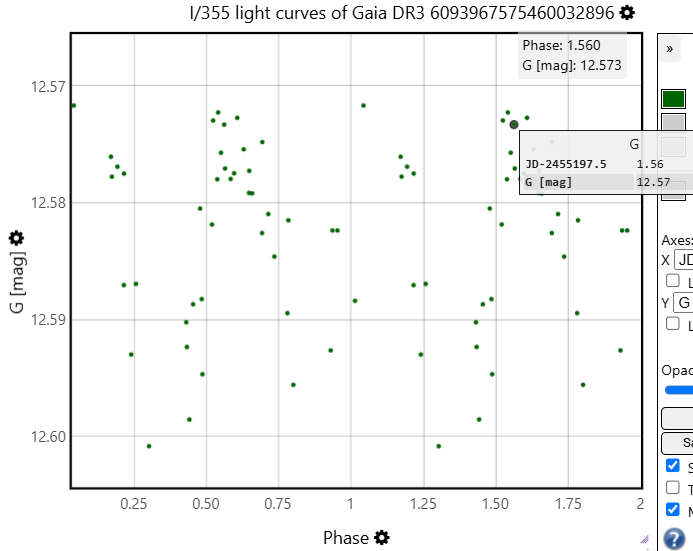


#### Beblend ASAS-SN data and plot combined results with initial period / epoch

C:\dev\_juypter\PH_TESS_LightCurveViewer\targets\..\lightkurve_ext.py:1297: RuntimeWarning: invalid value encountered in log10
  target_mag = contaminant_mag - 2.5 * np.log10(10 ** ((contaminant_mag - blended_mag) * 0.4) - 1)


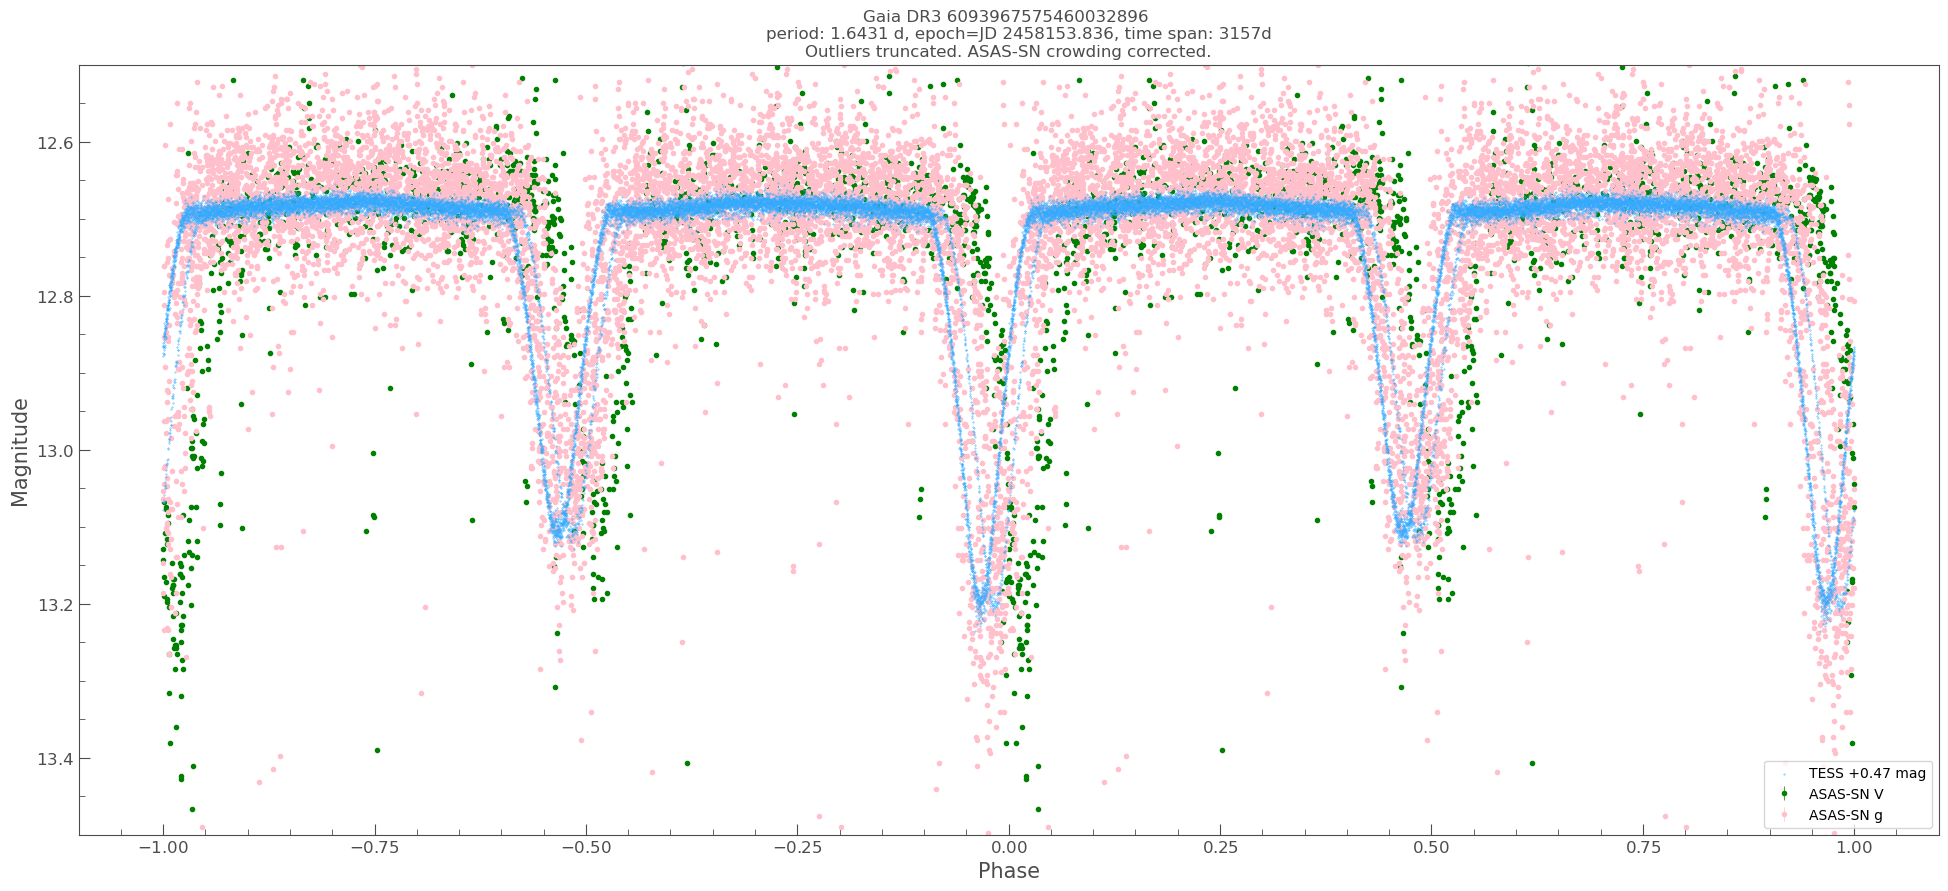

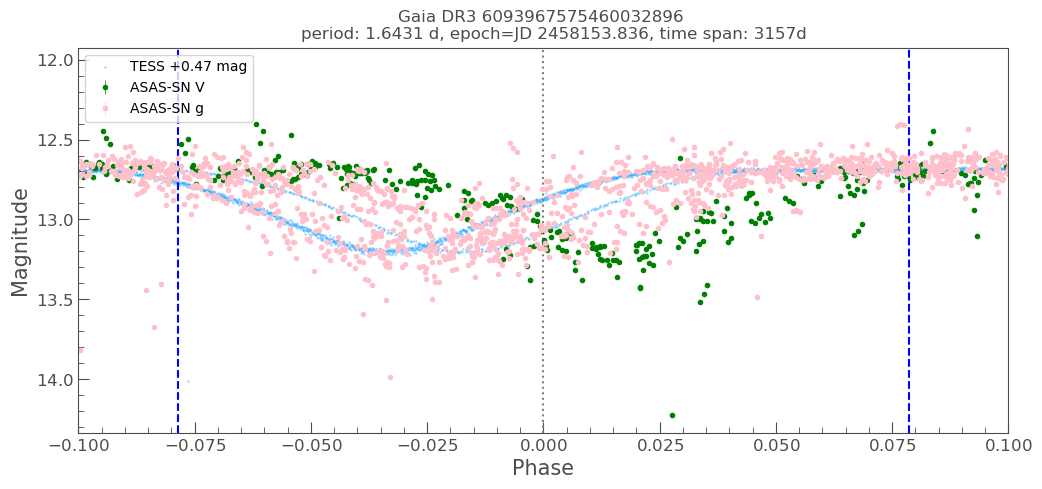

In [50]:
# reload(lke)
lc_asassn_v_c = lke.deblend_mag(lc_combined_dict["ASAS-SN V"].remove_nans(), contaminant_vmag)
# Note: for ASAS-SN g, we deblend the ASAS-SN g **zero-shfited to V**, 
lc_asassn_g_c = lke.deblend_mag(lc_combined_dict["ASAS-SN g"], contaminant_vmag) 

lc_combined_dict_c = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "ASAS-SN V": lc_asassn_v_c,
     "ASAS-SN g": lc_asassn_g_c,
    }, 
    shift_to="ASAS-SN V"  
)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
# plot_options[0][1]["s"] = 0.1  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[1][1]["markersize"] = 9  # make markers for Hp larger

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd , format="jd", scale="utc"),
    # epoch=Time(2448501.198, format="jd", scale="utc"),  # existing epoch in VSX
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ax.set_ylim(13.5, 12.5);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_initial,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details

# Copy the deblending result to VSX deblend spreadsheet to ensure the implementaion is correct
# lc_combined_dict["ASAS-SN V"].remove_nans().to_pandas().to_clipboard()
# lc_asassn_v_c.to_pandas()["flux"].to_clipboard()


## Refine epoch / period / duration

In [84]:
lcc = []
for key, lc in lc_combined_dict_c.items():
    lc = lc.copy()
    lc["source"] = key
    lcc.append(lke.to_normalized_flux_from_mag(lc))
lcc = lk.LightCurveCollection(lcc)
lc = lcc.stitch();

# axs = tplt.plot_skip_data_gap(lc);

# remove obvious outliers
lc = lc.truncate(0.5, 1.2, column="flux").remove_nans();


### First refinment: BLS on combined data

In [61]:
lc["quality"] = 0
lc["cadenceno"] = np.arange(0, len(lc))
lc.interact_bls();

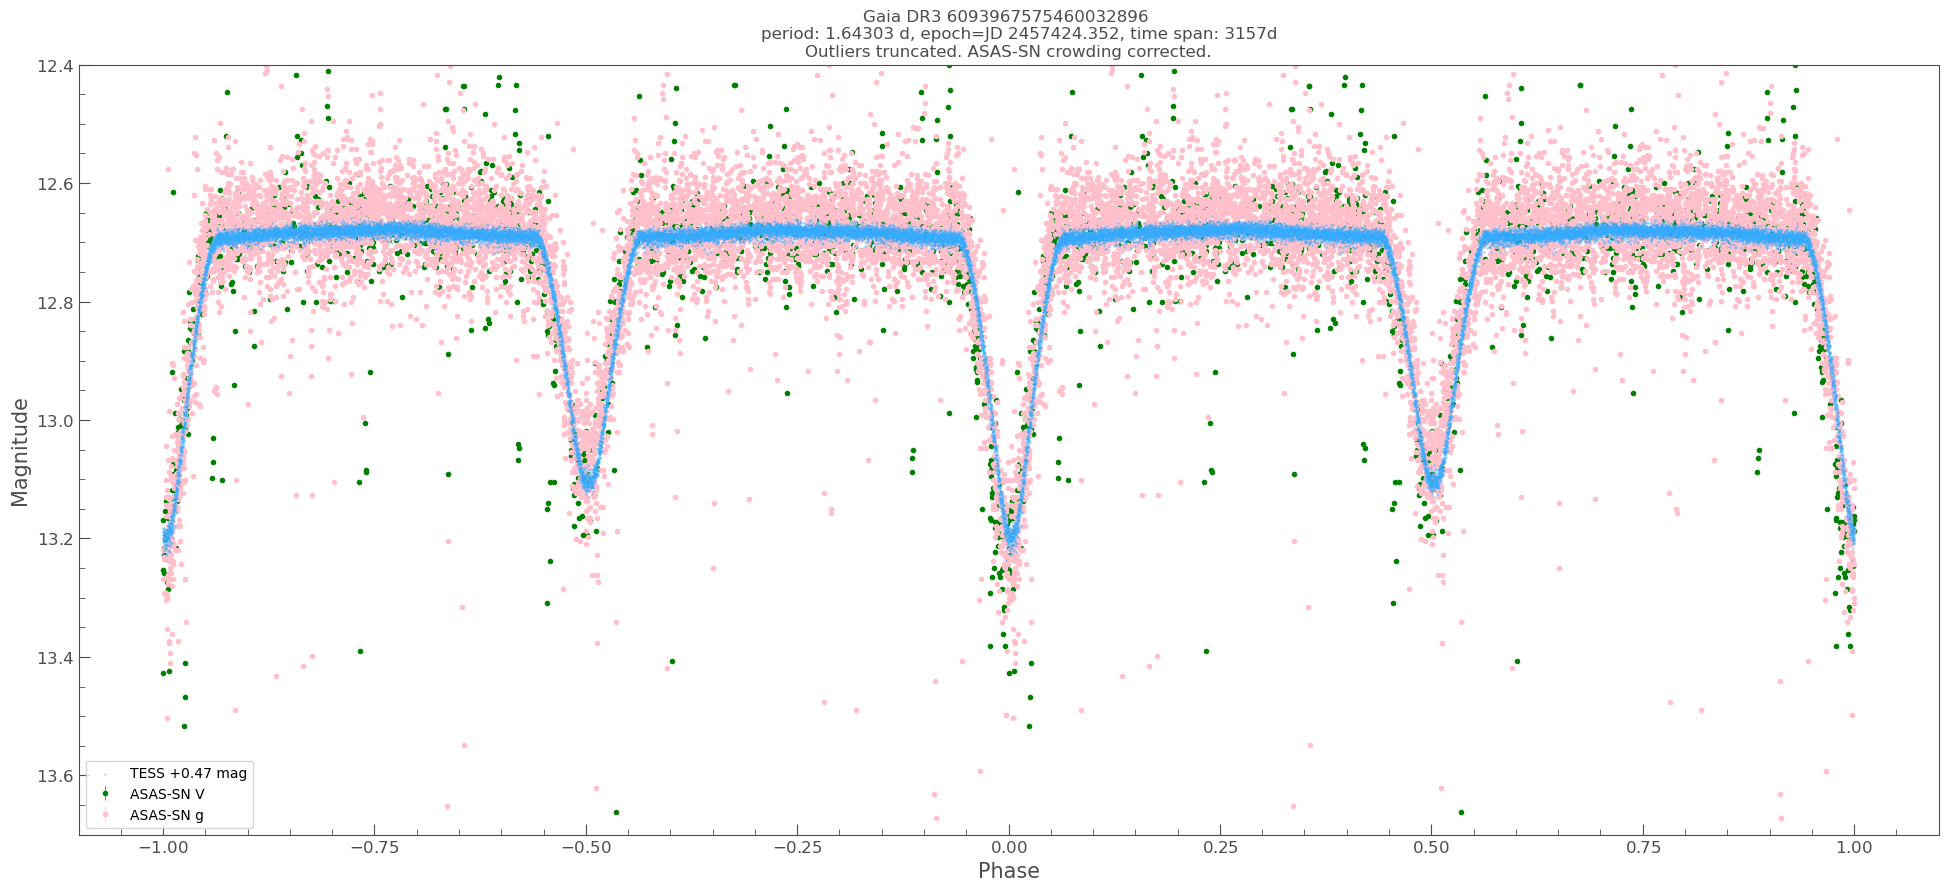

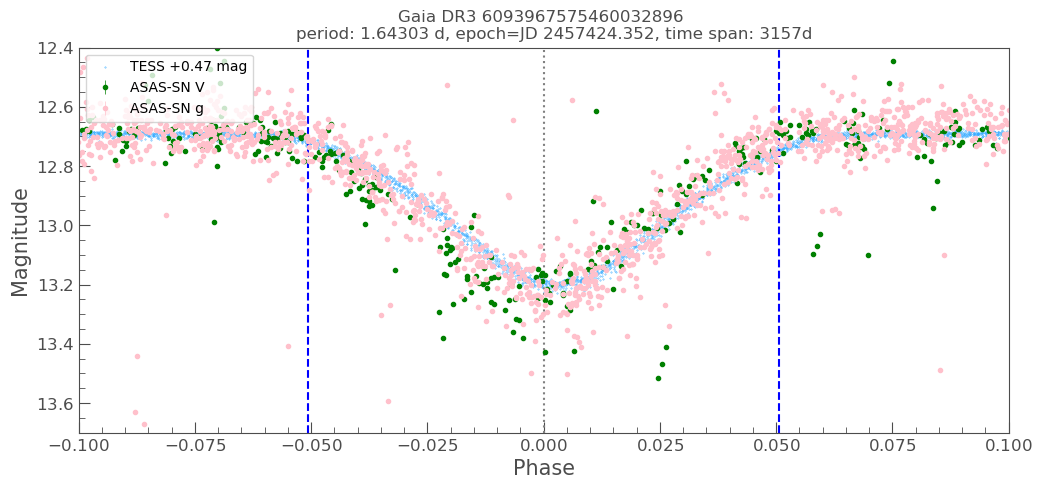

In [74]:
# from lc.interact_bls()
# period_trial = 1.6430784  # from lc.interact_bls(), duration: 0.1 d, BLS resolution: 4400
# epoch_time_hjd_trial = 2457424.29484  # from lc.interact_bls()
period_trial = 1.64303 # manual trial-and-error tweak from BLS reuslt 
epoch_time_hjd_trial = 2457424.352 # manual trial-and-error tweak from BLS reuslt: 2457424.29484 + period_trial * 0.035
duration_hr_min_i_trial = 4  # manual fit


ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial,
    epoch=Time(epoch_time_hjd_trial , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details

### 2nd refinement: use MCMC to model primary eclipses

len(lc_f_min_i): 2180


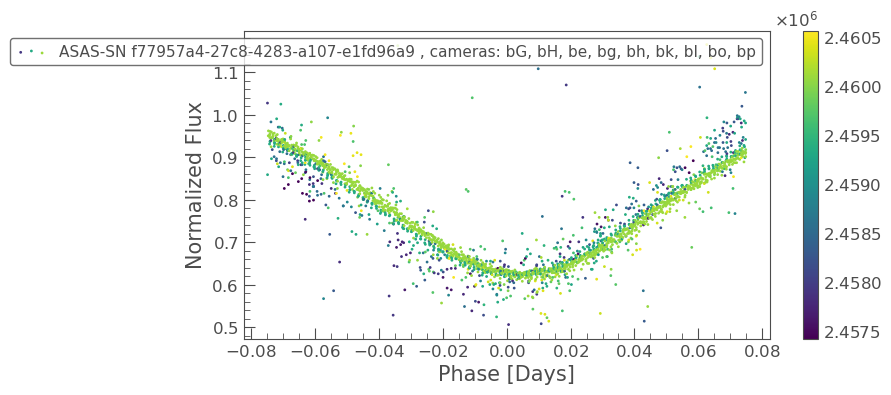

In [88]:
# Prepare the clipped LC for MCMC
lc_f_min_i = lc.fold(epoch_time=epoch_time_hjd_trial, period=period_trial)
lc_f_min_i = lc_f_min_i.truncate(0 - duration_hr_min_i_trial / 24 * 0.45, 0 + duration_hr_min_i_trial /24 * 0.45)
ax1 = tplt.scatter(lc_f_min_i, c=lc_f_min_i.time_original.value);
print("len(lc_f_min_i):", len(lc_f_min_i))


In [89]:
from types import SimpleNamespace

import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions
# reload(etv_functions)

lc_f = lc_f_min_i
lc_f = lc_f.remove_nans()
lc_f = lc_f.remove_nans(column="flux_err")

# # median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# # t0 in normalixed phase
start_vals = [1.0, -0.4, 0, 0.045, 0.9]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "0", *start_vals)

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

100%|██████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.49it/s]


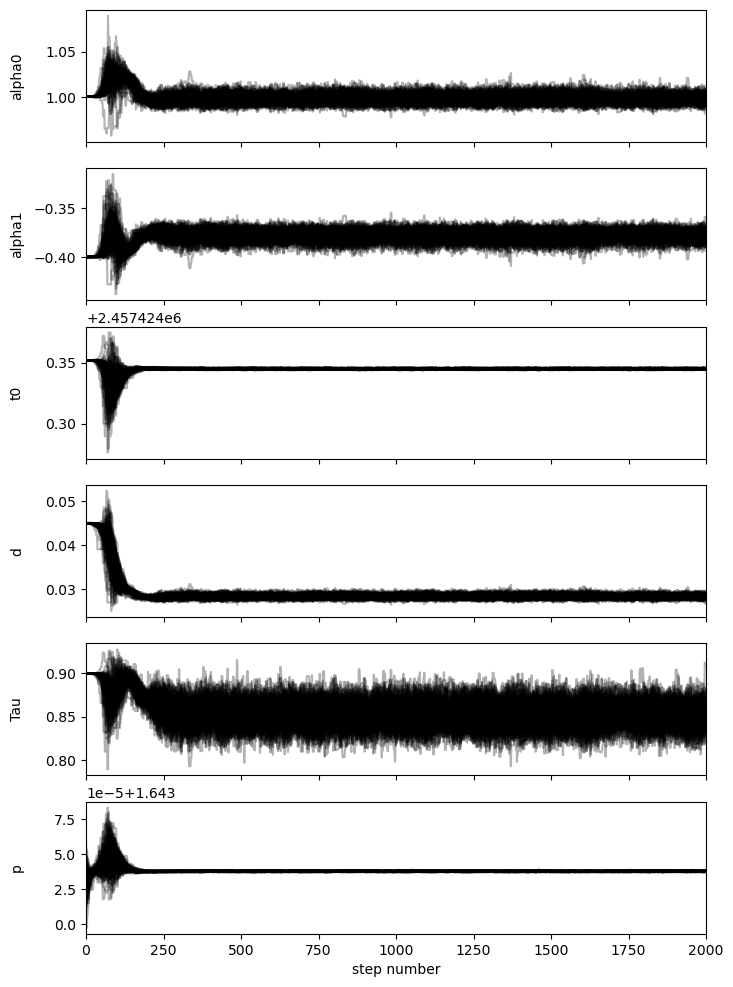

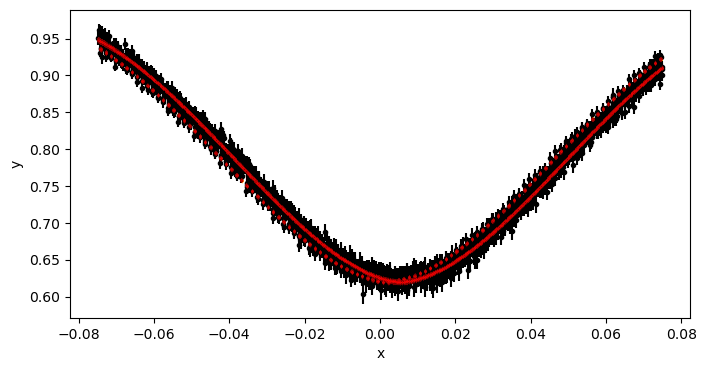

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9976548294985115, -0.3776706901718959, 2457424.3450087635, 0.028354040645499064, 0.8520014331800578, 1.6430376979922796
std_p: 2.7162954619850995e-07


In [91]:
mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats  = etvp.run_mcmc_initial_fit_p(
    lc_f_data, 
    [1.0, -0.4, epoch_time_hjd_trial, 0.045, 0.9, period_trial],
    nruns=2000, discard=1500,
    # nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
print("std_p:", fit_params_p_stats["std_p"])


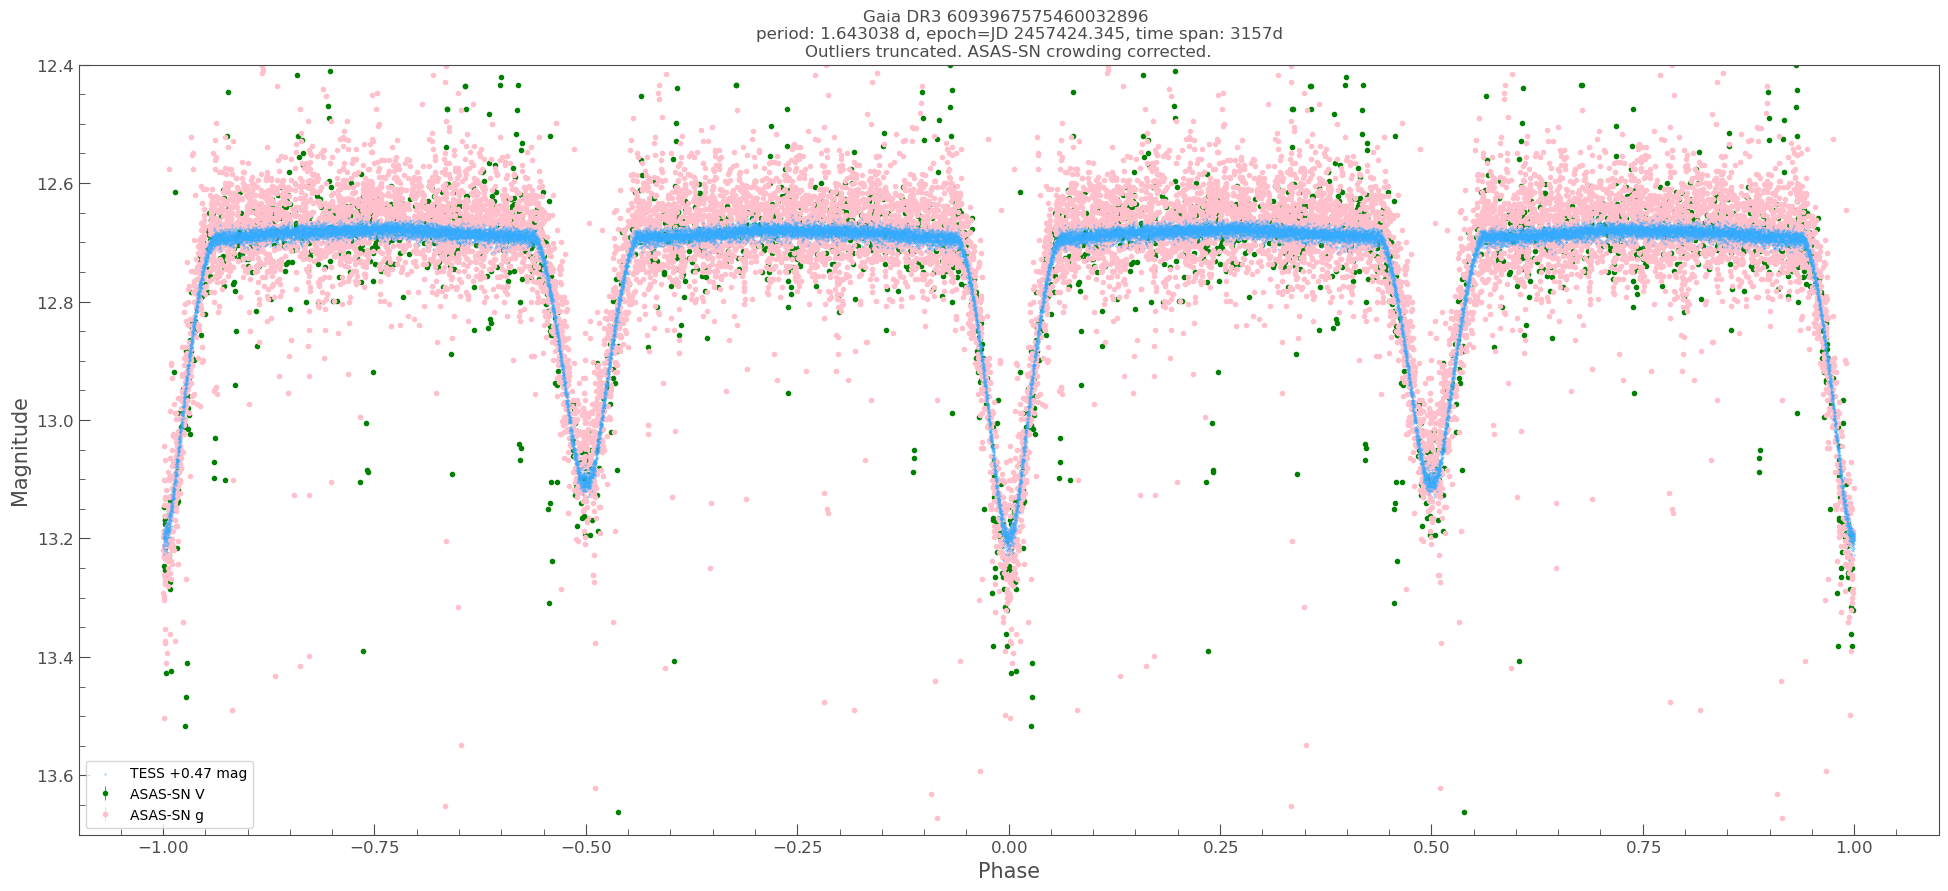

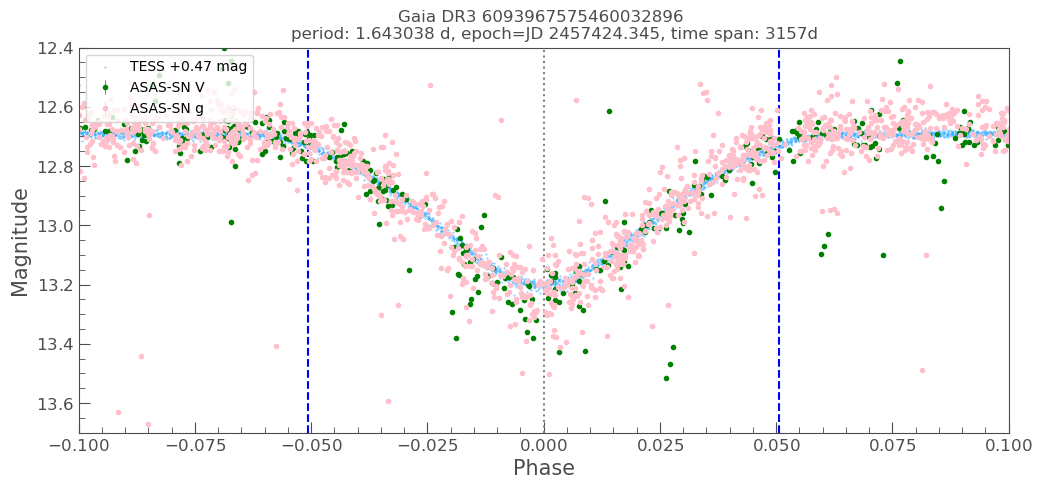

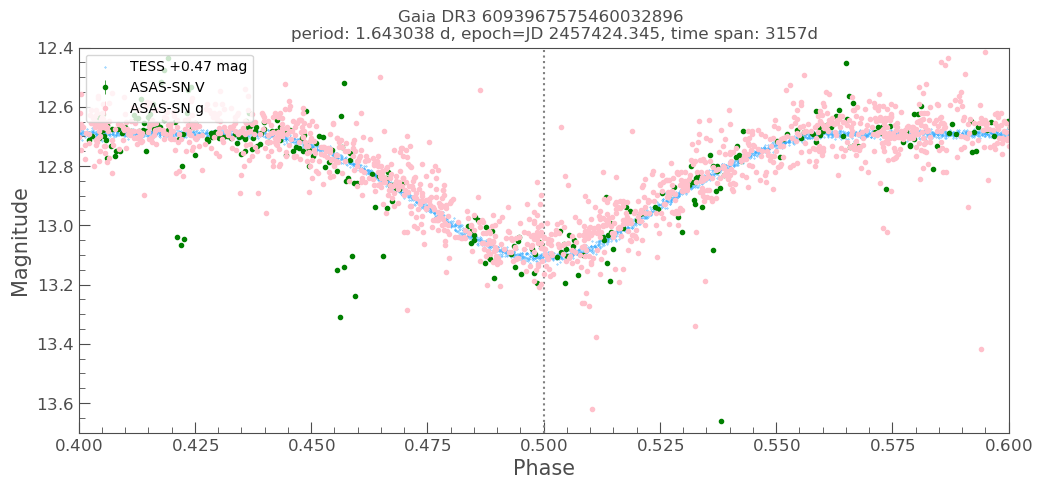

In [97]:
# MCMC
# mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 0.9976548294985115, -0.3776706901718959, 2457424.3450087635, 0.028354040645499064, 0.8520014331800578, 1.6430376979922796
# std_p: 2.7162954619850995e-07

period_trial2 = 1.643038  # MCMC 
epoch_time_hjd_trial2 = 2457424.345 # MCMC 
duration_hr_min_i_trial2 = 4  # manual fit
duration_hr_min_ii_trial2 = duration_hr_min_i_trial2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


# zoom plot
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_trial2,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.1, 0.1);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_trial2,
    epoch=Time(epoch_time_hjd_trial2 , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_trial2,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway
);
ax.set_ylim(*ylim);
ax.legend(loc="upper left");
ax.axvline(0.5, c="gray", linestyle="dotted");
ax.set_xlim(0.4, 0.6);  # to see primary in details

### Final epoch / period / duration

In [98]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_trial2
epoch_time_hjd_final = epoch_time_hjd_trial2
duration_hr_min_i_final = duration_hr_min_i_trial2 

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final)

# Min II : at phase 0.5


Adopted period / epoch / duration_hr:  1.643038 2457424.345 4


## Determine Amplitude (TESS) - SKIPPED

In [ ]:
# # From TESS data (shifted back to TESS mag)

# lc = lc_combined_dict["TESS"]
# lc = lc - lc.flux_shift
# # max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
# median_flux_mag = np.nanmedian(lc.flux.value)

# lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
# min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
# min_amp_mag = abs(min_flux_mag - median_flux_mag) 

# # fold around Min II, find the min flux
# lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - 0.25/24/60, 0 + 0.25/24/60)
# min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
# min_ii_amp_mag = abs(min_ii_flux_mag - median_flux_mag) 

# lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
# ax = tplt.scatter(lc_f, s=0.5);
# ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
# ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
# ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend();

# print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])
# print([f"{v:.2f}" for v in [median_flux_mag, min_amp_mag, min_ii_amp_mag]])

## Plots for VSX

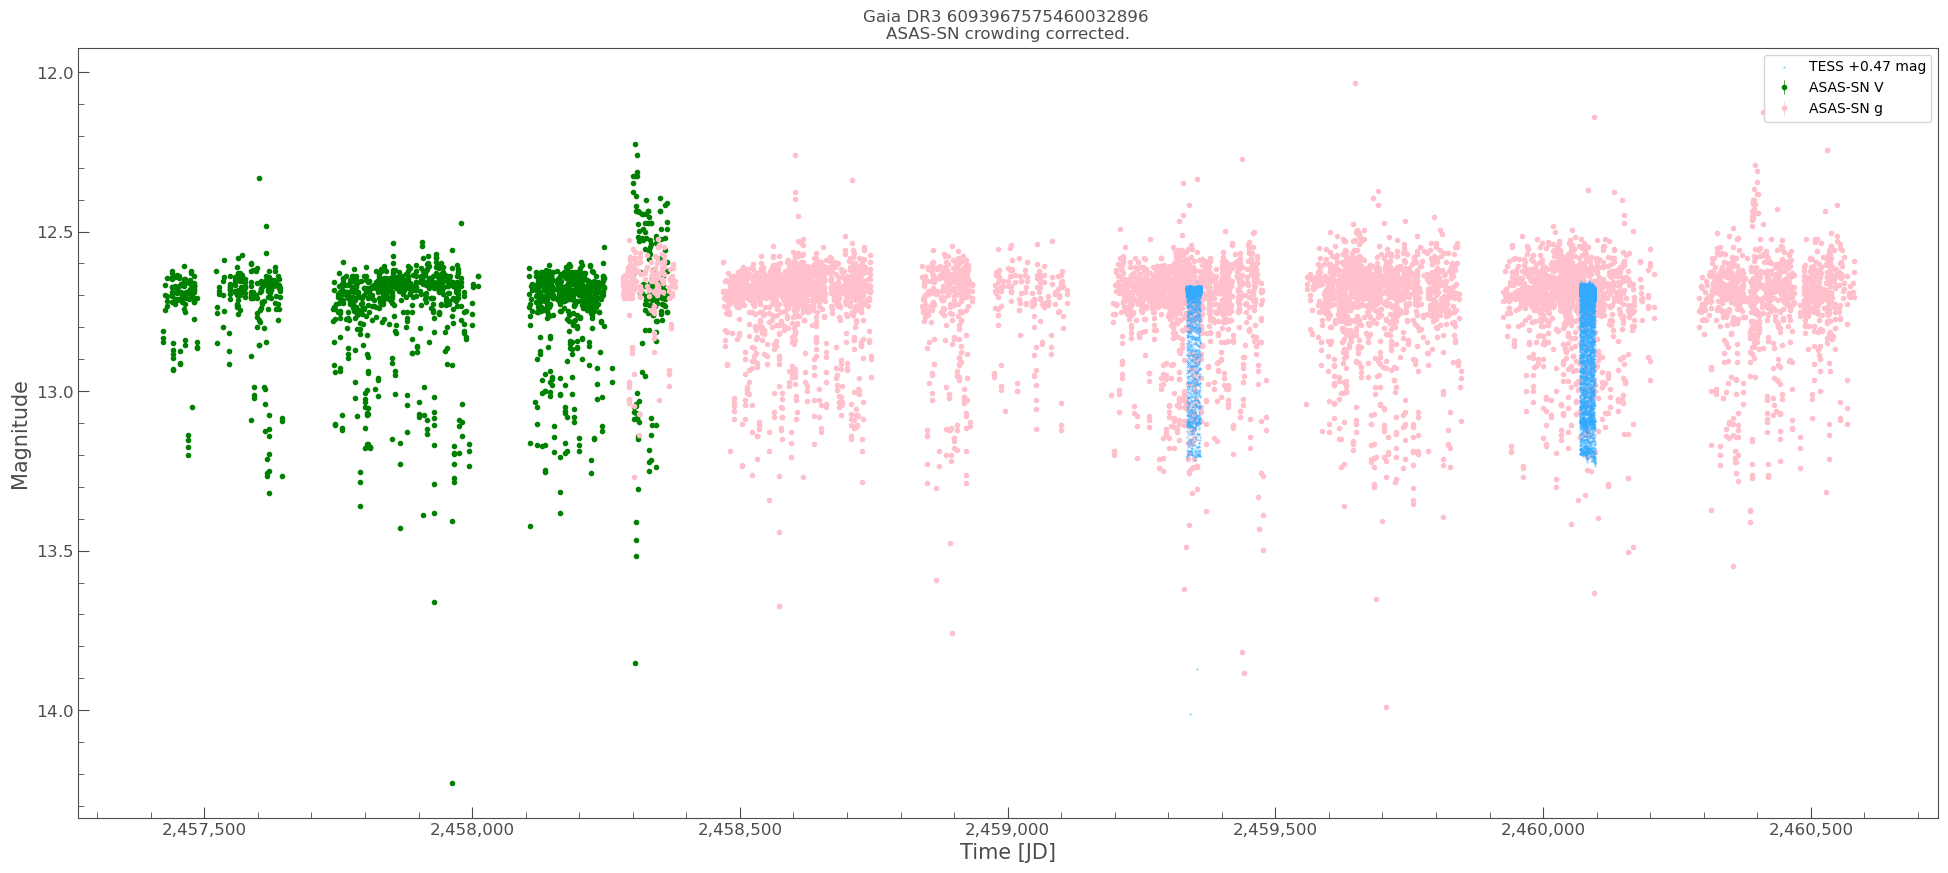

In [134]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict_c, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
ax.set_title(ax.get_title() + "\nASAS-SN crowding corrected.");

#### Phase Plot, with crowding correction 



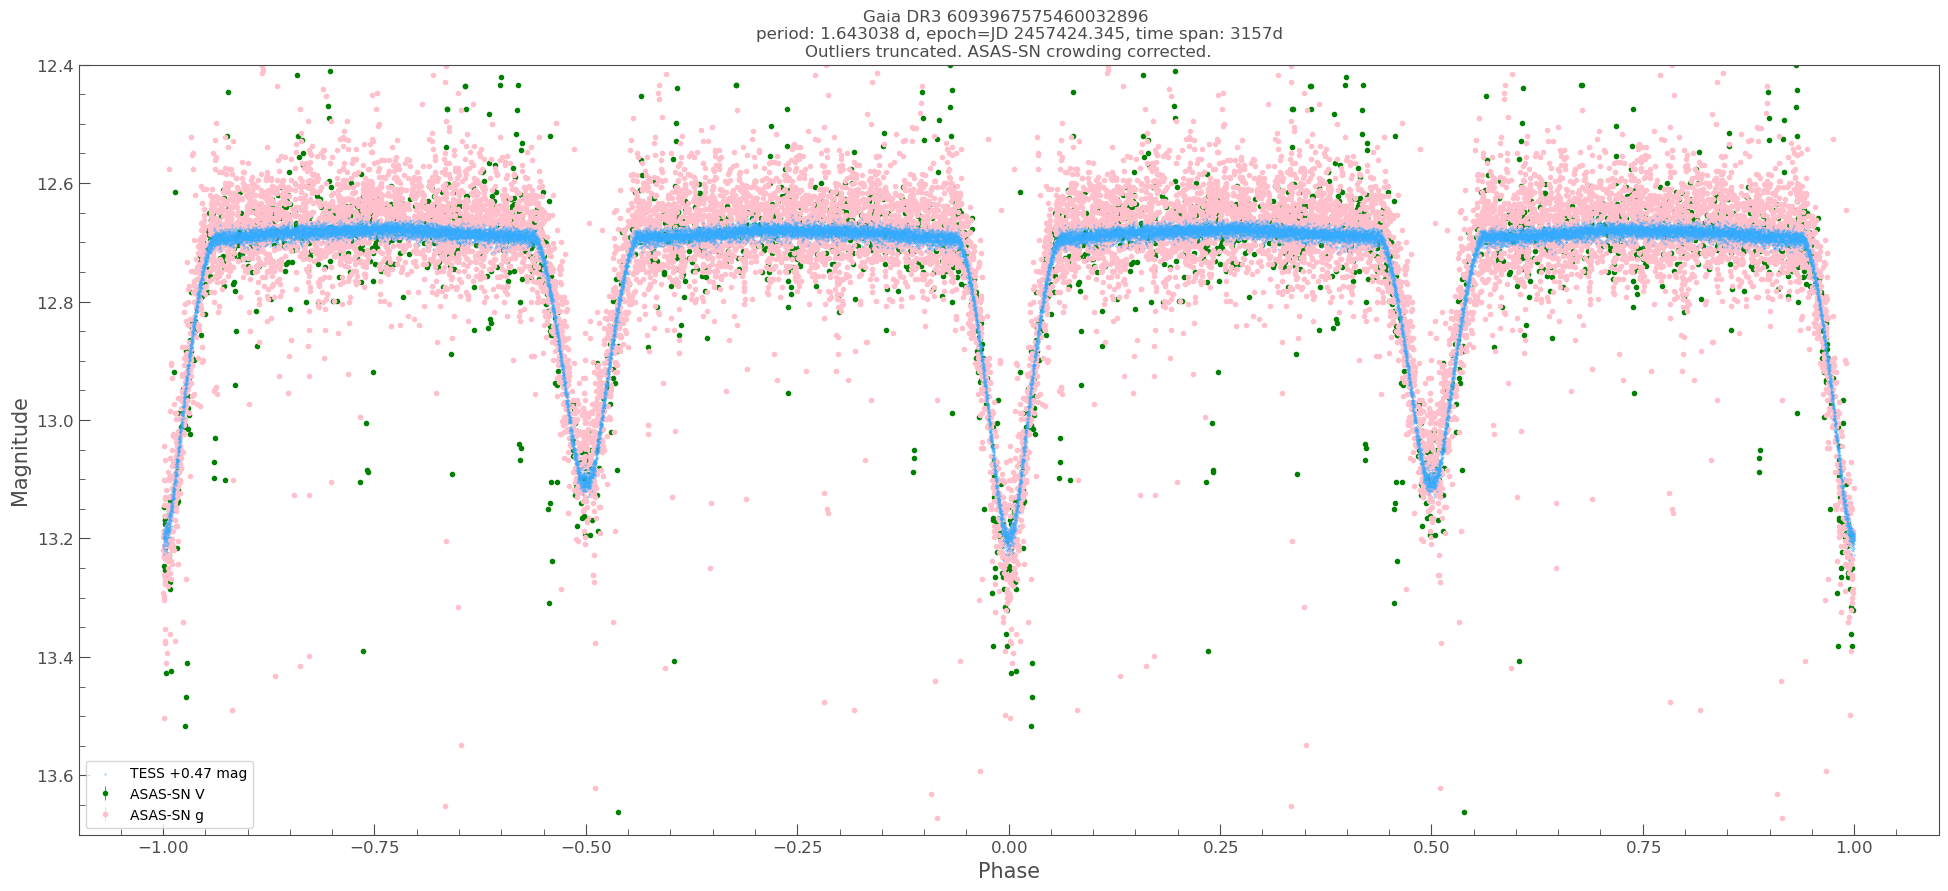

In [136]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict_c,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (13.7, 12.4)
ax.set_ylim(*ylim);
ax.set_title(ax.get_title() + "\nOutliers truncated. ASAS-SN crowding corrected.");


### Determine Magnitude Range (crowding corrected ASAS-SN V)

Min mag # num data points: 20
Max mag # num data points: 29
['12.69', '13.24']


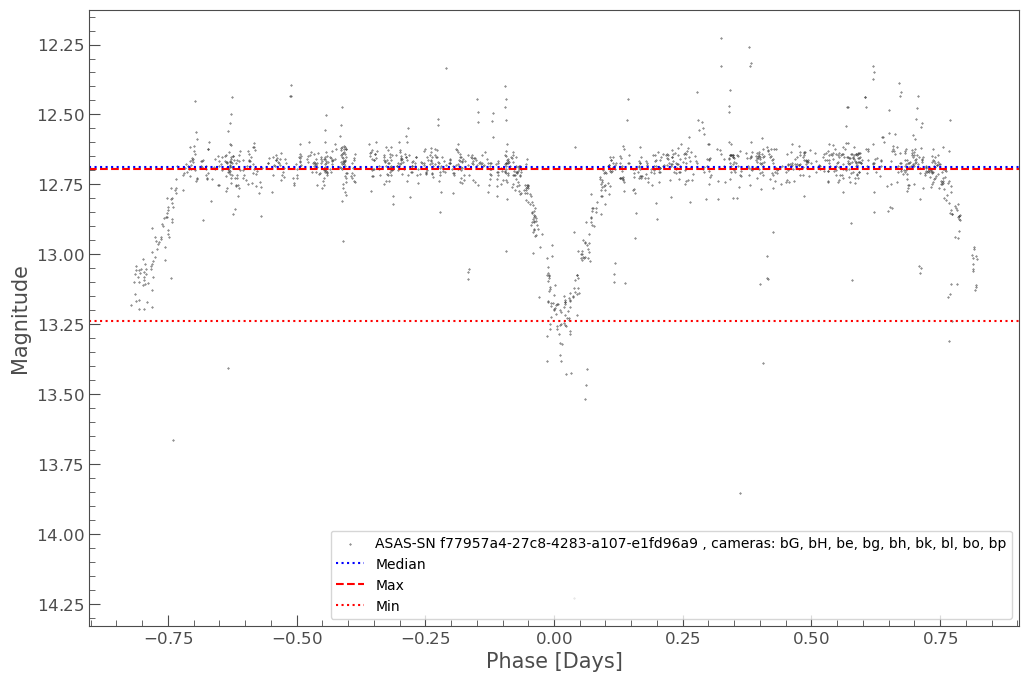

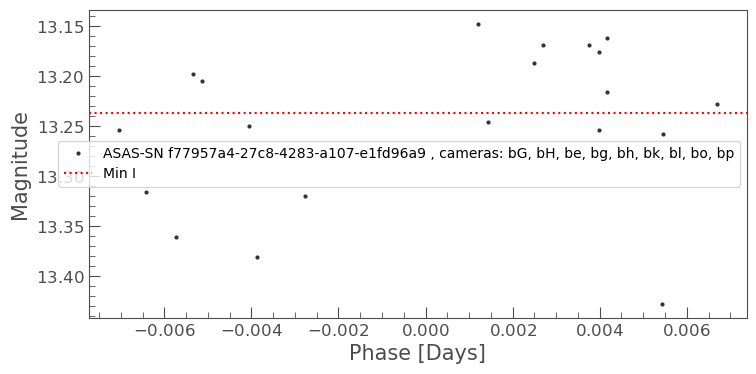

In [111]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict_c["ASAS-SN V"]
# lc = lc_combined_dict_c["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
print("Min mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

# fold around Min II, find the min flux
lc_zoom_max_p1 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.25, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max_p2 = lc.fold(epoch_time=epoch_time_hjd_final + period_final * 0.75, period=period_final).truncate(0 - 12/24/60, 0 + 12/24/60)
lc_zoom_max = lk.LightCurveCollection([lc_zoom_max_p1, lc_zoom_max_p2]).stitch(corrector_func=lambda lc: lc)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 1)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, s=0.5, ax=ax);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(max_flux_mag, c="red", linestyle="dashed", label="Max")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min")
ax.legend(loc="lower right");
# ax.set_xlim(-0.15, 0.15); ax.set_ylim(9.85, 9.3);  ax.axvline(0, c="gray", linestyle="dotted");  # zoom to Min

ax = tplt.scatter(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

# lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
# ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
# ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
# ax.legend(loc="lower right");

# Sebatsian suggestion: 9.46 - 9.76, based on corrected Hipparcos, INTEGRAL-OMC
print([f"{v:.2f}" for v in [max_flux_mag, min_flux_mag]])


## VSX Report Table

In [112]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [137]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  # include TIC, as Gaia DR3 is the primary name
other_names += ",UCAC4 205-078706"  # UCAC4 resolves the 2 stars -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ675e2d18351e6c&-out.add=.&-source=I/322A/out&UCAC4===205-078706

# TODO: OPEN add Min I, Min II amplitude 
remarks = f"""ASAS-SN data contaminated by Gaia DR3 6093967571164369920 (V={contaminant_vmag}; 2.9" to the W). Range has been corrected."""  

revision_comment = "Identification from 2022yCat.1358....0G. Period, epoch and eclipse duration from ASAS-SN and TESS data. Range from ASAS-SN V data. Position and spectral type from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    # Variable_Type="EA",  # no change
    Spectral_Type="F",  # from Gaia DR3 astrophysical parameters
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"{max_flux_mag:.2f}",
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{min_flux_mag:.2f}", 
    Minimum_Magnitude_band="V",  
    Minimum_Is_Amplitude=False,
    Period=period_final,
    Epoch=epoch_time_hjd_final,
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.0f}",
    # Discoverer="Gaia collaboration",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.GAIA_DR3_VAR_N,
    Reference0_Bib=BIBS.GAIA_DR3_VAR_B,
    Reference1_Name=BIBS.QLP_N,
    Reference1_Bib=BIBS.QLP_B,
    Reference2_Name=BIBS.ASAS_SN_N,
    Reference2_Bib=BIBS.ASAS_SN_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic1050594841_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
print("""
tic1050594841_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
""")


Other Names (1 line each):
TIC 1050594841
UCAC4 205-078706

ASAS-SN data contaminated by Gaia DR3 6093967571164369920 (V=12.13; 2.9" to the W). Range has been corrected.

Identification from 2022yCat.1358....0G. Period, epoch and eclipse duration from ASAS-SN and TESS data. Range from ASAS-SN V data. Position and spectral type from Gaia DR3.


,Field,Value
0,Position,"210.21844025625, -49.00404146133"
1,Primary_Name,Gaia DR3 6093967575460032896
2,Other_Names,"TIC 1050594841,UCAC4 205-078706"
3,Spectral_Type,F
4,Spectral_Type_Uncertain,False
5,Maximum_Magnitude,12.69
6,Maximum_Magnitude_band,V
7,Minimum_Magnitude,13.24
8,Minimum_Magnitude_band,V
9,Minimum_Is_Amplitude,False



tic1050594841_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.



# Scratch